**Before you dive into the implementations, I highly recommend first learning the heart of each concept —its core idea and where we use. You can explore this through YouTube tutorials, books, or online courses. This repository is meant to complement that knowledge by showing how to translate concepts into working code.**


**Probabilistic Latent Semantic Analysis (PLSA)**


PLSA is a statistical technique for discovering latent (hidden) topics in text data. It models documents as mixtures of topics, where each topic is a distribution over words. PLSA uses the Expectation-Maximization (EM) algorithm to estimate:


  The probability of a word given a topic: P(word∣topic).

  The probability of a topic given a document: P(topic∣document).



In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from collections import defaultdict

In [37]:
# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
# Load dataset (example using 20 Newsgroups)
newsgroups = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
documents = newsgroups.data[:500]  # Using first 500 documents for demonstration

**Preprocessing:**


  Text cleaning (lowercasing, special character removal)

  Stopword removal
  
  lemmatizatin

  Document-Term Matrix creation

In [39]:
# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define preprocessing function
def preprocess(text):
    # Lowercase the text
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Join tokens back into a single string
    return ' '.join(tokens)

# Apply preprocessing to each document
processed_docs = [preprocess(doc) for doc in documents]


500


In [40]:
# Create document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000)
dtm = vectorizer.fit_transform(processed_docs)
vocab = vectorizer.get_feature_names_out()

**PLSA Implementation:**


  EM algorithm implementation

  Parameter initialization

  E-step (posterior calculation)

  M-step (parameter updates)


In [51]:
import numpy as np

class PLSA:
    def __init__(self, n_topics, max_iter=100):
        self.n_topics = n_topics
        self.max_iter = max_iter

    def fit(self, dtm):
        n_docs, n_words = dtm.shape

        # Initialize parameters
        self.p_z_dw = np.random.rand(n_docs, n_words, self.n_topics)
        self.p_z = np.random.rand(self.n_topics)
        self.p_w_z = np.random.rand(self.n_topics, n_words)
        self.p_d_z = np.random.rand(n_docs, self.n_topics)

        # Convert DTM to dense matrix
        self.dtm = dtm.toarray()

        for iteration in range(self.max_iter):
            # E-step
            for d in range(n_docs):
                for w in range(n_words):
                    total = 0
                    for z in range(self.n_topics):
                        self.p_z_dw[d, w, z] = self.p_w_z[z, w] * self.p_d_z[d, z]
                        total += self.p_z_dw[d, w, z]
                    if total > 0:
                        self.p_z_dw[d, w, :] /= total

            # M-step
            # Update p(w|z)
            for z in range(self.n_topics):
                total = 0
                for w in range(n_words):
                    self.p_w_z[z, w] = np.sum(self.dtm[:, w] * self.p_z_dw[:, w, z])
                    total += self.p_w_z[z, w]
                if total > 0:
                    self.p_w_z[z, :] /= total

            # Update p(z|d)
            for d in range(n_docs):
                for z in range(self.n_topics):
                    self.p_d_z[d, z] = np.sum(self.dtm[d, :] * self.p_z_dw[d, :, z])
                    if np.sum(self.p_d_z[d, :]) > 0:
                        self.p_d_z[d, :] /= np.sum(self.p_d_z[d, :])

        return self.p_w_z, self.p_d_z


In [52]:
# Initialize and train PLSA
n_topics = 5
plsa = PLSA(n_topics=n_topics, max_iter=50)
p_w_z, p_d_z = plsa.fit(dtm)


**Visualization:**


  Top words per topic

  Word clouds for topic visualization

In [54]:
# Display top words per topic
def display_topics(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.p_w_z):
      print(f"Topic {topic_idx}:")
      print(" ".join([feature_names[i]
                       for i in topic.argsort()[:-n_top_words - 1:-1]]))

display_topics(plsa, vocab)

Topic 0:
israel yes oh talking congress tax current anyway possible leaf
Topic 1:
problem battery thread deleted anyone seriously christianity comment expected smaller
Topic 2:
car mail test engine appreciated bear morality hot cup internal
Topic 3:
thanks window file email looking program sale please xr color
Topic 4:
one would get people know dont like time think use


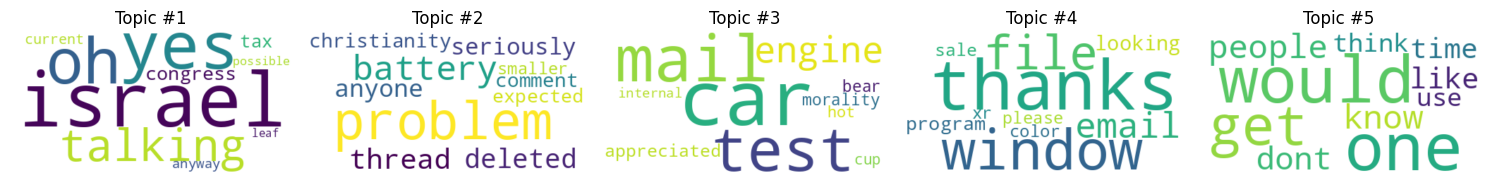

In [62]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# Number of topics to display
n_topics_to_display = 5
n_words_per_topic = 10

# Get the indices of the top 5 topics
top_topics_indices = np.argsort(np.sum(p_w_z, axis=1))[-n_topics_to_display:]

# Create a figure with subplots arranged horizontally
fig, axes = plt.subplots(1, n_topics_to_display, figsize=(15, 5))

for i, topic_idx in enumerate(top_topics_indices):
    # Get the indices of the top 10 words for the current topic
    top_words_indices = np.argsort(p_w_z[topic_idx, :])[-n_words_per_topic:]

    # Create a dictionary of word frequencies for the word cloud
    word_freq = {vocab[i]: p_w_z[topic_idx, i] for i in top_words_indices}

    # Generate the word cloud
    wordcloud = WordCloud(
        width=400,
        height=200,
        background_color='white',
        prefer_horizontal=1.0  # Ensures words are horizontal
    ).generate_from_frequencies(word_freq)

    # Display the word cloud in the corresponding subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis("off")
    axes[i].set_title(f"Topic #{topic_idx + 1}")

plt.tight_layout()
plt.show()



**Improvement Suggestions:**

  Add TF-IDF weighting

  Implement log-likelihood convergence check

  Add perplexity calculation

  Include coherence score evaluation

  Try different initialization strategies



**Key Drawbacks of PLSA**




  **No Generative Model for New Documents**

  PLSA learns topic distributions only for the training documents. It cannot naturally infer topics for unseen documents, limiting real-time applications.



  **Overfitting Risk**

  The EM algorithm optimizes parameters directly on training data without regularization (e.g., Bayesian priors). This can lead to overfitting, especially with many topics or sparse data.



  **Computational Scalability**

  EM iterations involve computations across all documents, words, and topics, making PLSA slow for large datasets.



  **Storage Overhead**

  PLSA stores document-topic probabilities (P(topic∣document)) for all training documents, which becomes memory-intensive for large corpora.



  **Non-Bayesian Framework**

  Unlike LDA (Latent Dirichlet Allocation), PLSA treats topics as fixed parameters rather than probabilistic distributions. This limits flexibility and robustness.





